Seeing the overview of the data

In [2]:
import pandas as pd

# Import dataset
df = pd.read_csv("Bengaluru_House_Data.csv")
print(df.shape)
print(df.info())
print(df.head())


(13320, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB
None
              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To

Checking statistics

In [3]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [4]:
df.nunique()

,0
area_type,4
availability,81
location,1305
size,31
society,2688
total_sqft,2117
bath,19
balcony,4
price,1994


In [5]:
df['location'].value_counts()

,count
location,
Whitefield,540
Sarjapur Road,399
Electronic City,302
Kanakpura Road,273
Thanisandra,234
...,...
3rd Stage Raja Rajeshwari Nagar,1
Chuchangatta Colony,1
"Electronic City Phase 1,",1


In [6]:
df['location'].nunique()

1305

In [7]:
df['area_type'].value_counts()

,count
area_type,
Super built-up Area,8790
Built-up Area,2418
Plot Area,2025
Carpet Area,87


Dropping useless columns

In [8]:
df.drop(columns=['society', 'availability'], inplace=True)

Handle missing values

In [9]:
# Check missing values
print(df.isnull().sum())

area_type       0
location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64


Drop rows with missing values, and drop the balcony column completely as it has too many missing values

In [10]:
# Drop rows with missing location, size, or bath
df.dropna(subset=['location', 'size', 'bath'], inplace=True)

# Drop balcony
df.drop(columns=['balcony'], inplace=True)

Converting size to numeric

In [11]:
df['bhk'] = df['size'].str.extract('(\d+)').astype(float)
df.drop(columns=['size'], inplace=True)

Handle total_sqft (incase there is a range, in which case it will take the midpoint)

In [12]:
def convert_sqft_to_num(x):
    try:
        if '-' in str(x):
            a, b = x.split('-')
            return (float(a) + float(b)) / 2
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)
df.dropna(subset=['total_sqft'], inplace=True)

Encoding categorical variables (in case of rare locations, we group them in other)

In [13]:
location_counts = df['location'].value_counts()
rare_locations = location_counts[location_counts < 10].index
df['location'] = df['location'].apply(lambda x: 'other' if x in rare_locations else x)

Converting to one-hot encoding:

In [14]:
df = pd.get_dummies(df, columns=['location', 'area_type'], drop_first=True)

# making a copy of the dataframe for each model

In [15]:
df_knn = df.copy()
df_tree = df.copy()

Scaling features

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = ['total_sqft', 'bath', 'bhk']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

Defining target variable

In [17]:
# X = all features except 'price'
X = df.drop(columns=['price'])

# y = target variable
y = df['price']

Correlation heatmap of numeric features

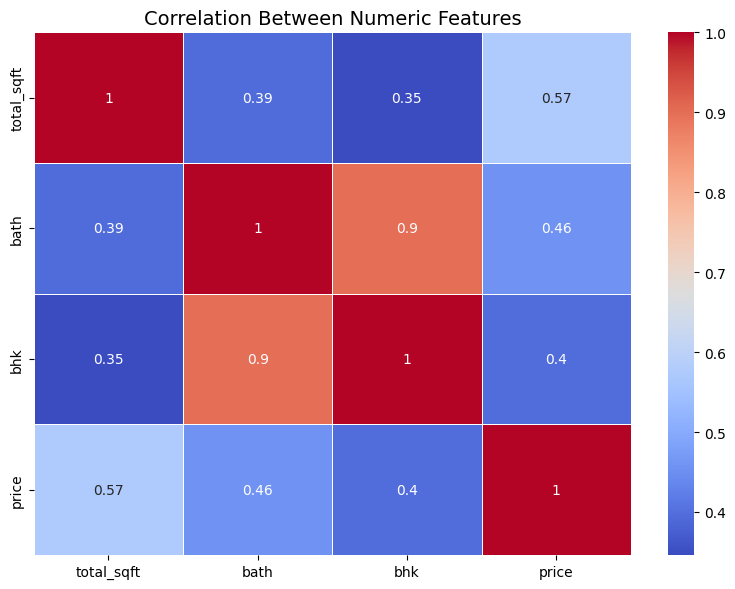

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter numeric columns
numeric_cols = ['total_sqft', 'bath', 'bhk', 'price']
numeric_df = df[numeric_cols]  # use your cleaned df

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Between Numeric Features", fontsize=14)
plt.tight_layout()
plt.show()

# Starting with linear regression (normal)

adding bias term

In [19]:
import numpy as np

# Converting all features to float
X = X.astype(float)

# Converting to NumPy arrays for normal equation multiplication
X_np = X.values
y_np = y.values.reshape(-1, 1)

# bias term
X_b = np.hstack([np.ones((X_np.shape[0], 1)), X_np])

# Train-test split
from sklearn.model_selection import train_test_split
X_train_b, X_test_b, y_train, y_test = train_test_split(X_b, y_np, test_size=0.2, random_state=42)

# the normal equation
theta = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train


making predictions

In [20]:
y_pred = X_test_b @ theta

evaluate with metrics

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} lakhs")
print(f"RMSE: {rmse:.2f} lakhs")
print(f"R² Score: {r2:.2f}")

MAE: 40.68 lakhs
RMSE: 87.24 lakhs
R² Score: 0.57


visualise predictions

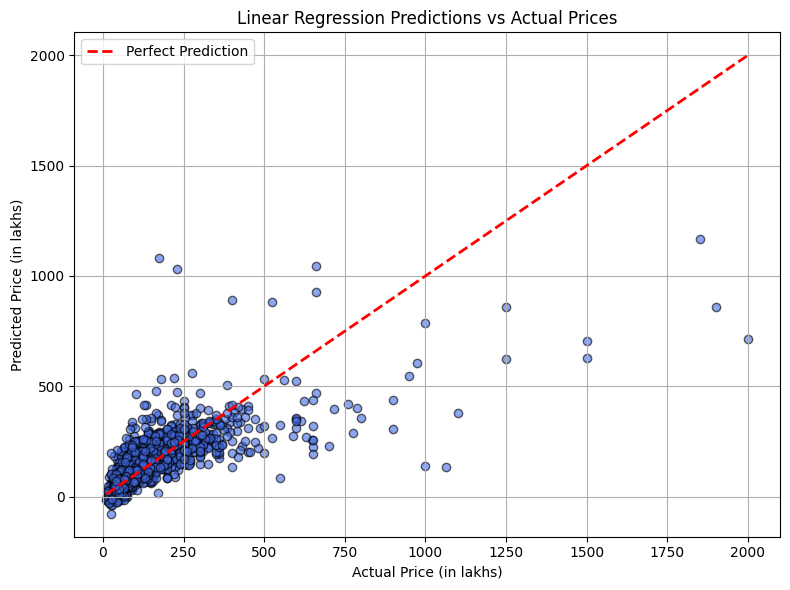

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='royalblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.xlabel("Actual Price (in lakhs)")
plt.ylabel("Predicted Price (in lakhs)")
plt.title("Linear Regression Predictions vs Actual Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Trying ridge regression

define ridge regression function

In [23]:
def ridge_regression(X, y, lambda_):
    # get number of features/columns in X
    n_features = X.shape[1]

    # Identity matrix for regularisation (but not for intercept)
    I = np.eye(n_features)
    I[0, 0] = 0  # don't penalise the bias term/intercept

    # Ridge formula
    theta = np.linalg.inv(X.T @ X + lambda_ * I) @ X.T @ y
    return theta

try multiple values of lambda

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

best_r2 = -1
best_lambda = None

for lambda_ in [0, 1, 10, 100, 1000]:
    theta = ridge_regression(X_train_b, y_train, lambda_)
    y_pred = X_test_b @ theta

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"λ={lambda_} → R²={r2:.2f}, MAE={mae:.2f}, RMSE={rmse:.2f}")

    if r2 > best_r2:
        best_r2 = r2
        best_lambda = lambda_

λ=0 → R²=0.57, MAE=40.68, RMSE=87.24
λ=1 → R²=0.57, MAE=40.48, RMSE=87.21
λ=10 → R²=0.56, MAE=40.10, RMSE=88.63
λ=100 → R²=0.51, MAE=41.34, RMSE=92.82
λ=1000 → R²=0.47, MAE=43.37, RMSE=96.65


report final best ridge model

In [25]:
# Retrain on best lambda
theta_best = ridge_regression(X_train_b, y_train, best_lambda)
y_pred_best = X_test_b @ theta_best

mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2 = r2_score(y_test, y_pred_best)

print(f"\nBest λ={best_lambda}")
print(f"Final Ridge MAE: {mae:.2f} lakhs")
print(f"Final Ridge RMSE: {rmse:.2f} lakhs")
print(f"Final Ridge R² Score: {r2:.2f}")


Best λ=1
Final Ridge MAE: 40.48 lakhs
Final Ridge RMSE: 87.21 lakhs
Final Ridge R² Score: 0.57


plot for this

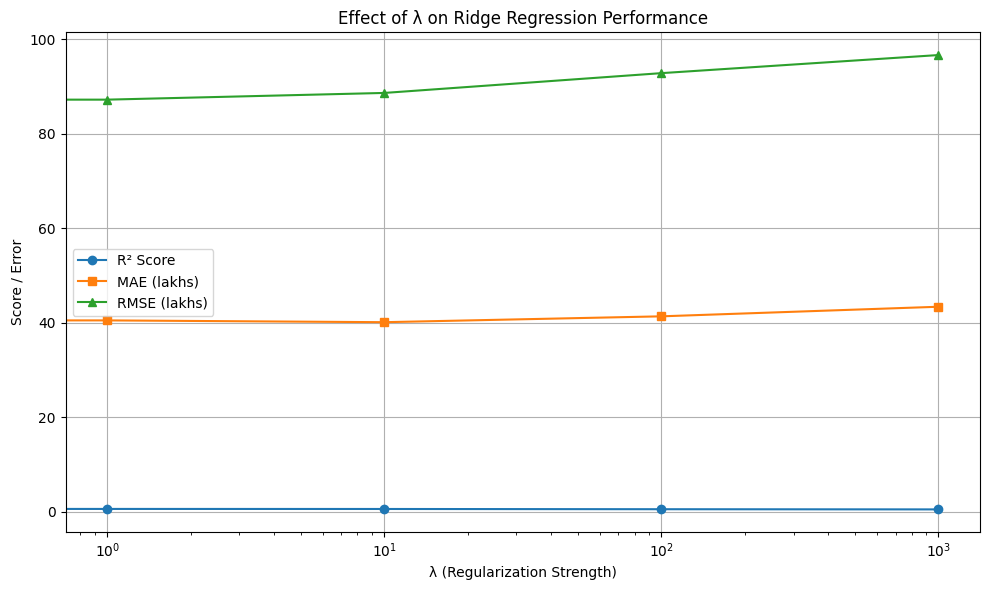

In [26]:
import matplotlib.pyplot as plt

# Values of lambda tested
lambdas = [0, 1, 10, 100, 1000]

# Corresponding performance metrics
r2_scores = [0.57, 0.57, 0.56, 0.51, 0.47]
maes = [40.68, 40.48, 40.10, 41.34, 43.37]
rmses = [87.24, 87.21, 88.63, 92.82, 96.65]

# Plot
plt.figure(figsize=(10, 6))

plt.plot(lambdas, r2_scores, marker='o', label='R² Score')
plt.plot(lambdas, maes, marker='s', label='MAE (lakhs)')
plt.plot(lambdas, rmses, marker='^', label='RMSE (lakhs)')

plt.xscale('log')  # Log scale for λ
plt.xlabel('λ (Regularization Strength)')
plt.ylabel('Score / Error')
plt.title('Effect of λ on Ridge Regression Performance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# didn't go so well, so we try a **decision tree regressor**

define helper functions

In [27]:
def mse(y):
    if len(y) == 0:
        return 0
    return np.mean((y - np.mean(y)) ** 2)

def best_split(X, y):
    best_feature, best_value = None, None
    best_error = float('inf')

    n_samples, n_features = X.shape

    for feature in range(n_features):
        values = np.unique(X[:, feature])
        for val in values:
            left_mask = X[:, feature] <= val
            right_mask = X[:, feature] > val

            if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
                continue

            error = (len(y[left_mask]) * mse(y[left_mask]) +
                     len(y[right_mask]) * mse(y[right_mask])) / len(y)

            if error < best_error:
                best_feature = feature
                best_value = val
                best_error = error

    return best_feature, best_value

define custom regressor class

In [28]:
class DecisionTreeRegressor:
    def __init__(self, max_depth=5, min_samples_split=10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y, depth=0):
        n_samples, n_features = X.shape

        if depth >= self.max_depth or n_samples < self.min_samples_split:
            return np.mean(y)

        feature, value = best_split(X, y)

        if feature is None:
            return np.mean(y)

        left_mask = X[:, feature] <= value
        right_mask = X[:, feature] > value

        left_subtree = self.fit(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.fit(X[right_mask], y[right_mask], depth + 1)

        return {
            'feature': feature,
            'value': value,
            'left': left_subtree,
            'right': right_subtree
        }

    def predict_one(self, x, node):
        if not isinstance(node, dict):
            return node

        if x[node['feature']] <= node['value']:
            return self.predict_one(x, node['left'])
        else:
            return self.predict_one(x, node['right'])

    def predict(self, X):
        return np.array([self.predict_one(x, self.tree) for x in X])

train and evaluate model

In [29]:
# Define X and y
X_tree = df_tree.drop(columns=['price'])
y_tree = df_tree['price']

# Convert to NumPy
X_tree_np = X_tree.values.astype(np.float64)
y_tree_np = y_tree.values.astype(np.float64)

# Train-test split
from sklearn.model_selection import train_test_split
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_tree_np, y_tree_np, test_size=0.2, random_state=42
)

# Train the custom Decision Tree
tree = DecisionTreeRegressor(max_depth=7, min_samples_split=5)
tree.tree = tree.fit(X_train_tree, y_train_tree)

# Predict
y_pred_tree = tree.predict(X_test_tree)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test_tree, y_pred_tree)
rmse = np.sqrt(mean_squared_error(y_test_tree, y_pred_tree))
r2 = r2_score(y_test_tree, y_pred_tree)

print(f"Decision Tree MAE: {mae:.2f} lakhs")
print(f"Decision Tree RMSE: {rmse:.2f} lakhs")
print(f"Decision Tree R² Score: {r2:.2f}")

Decision Tree MAE: 35.82 lakhs
Decision Tree RMSE: 85.19 lakhs
Decision Tree R² Score: 0.59


plot

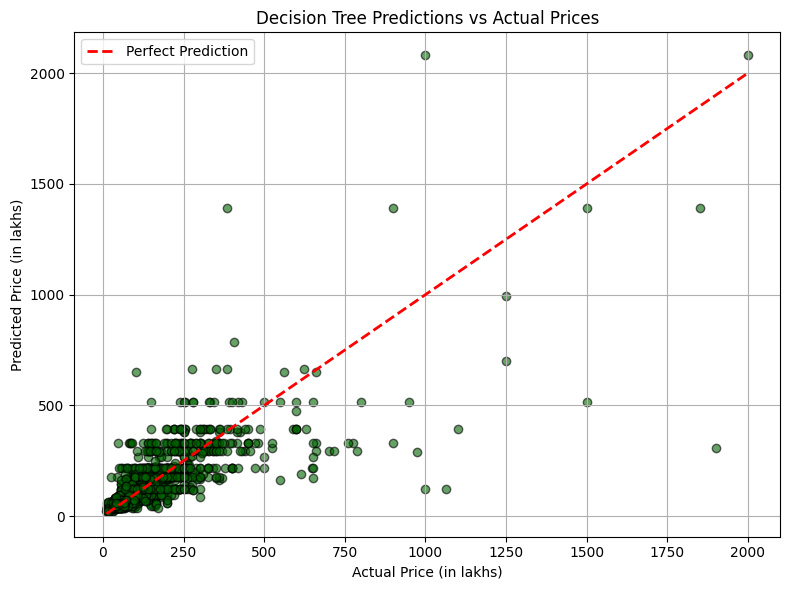

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_tree, alpha=0.6, color='darkgreen', edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.xlabel("Actual Price (in lakhs)")
plt.ylabel("Predicted Price (in lakhs)")
plt.title("Decision Tree Predictions vs Actual Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Capping at 5 crore and retraining

Capped Decision Tree R² (≤ ₹500L): 0.66


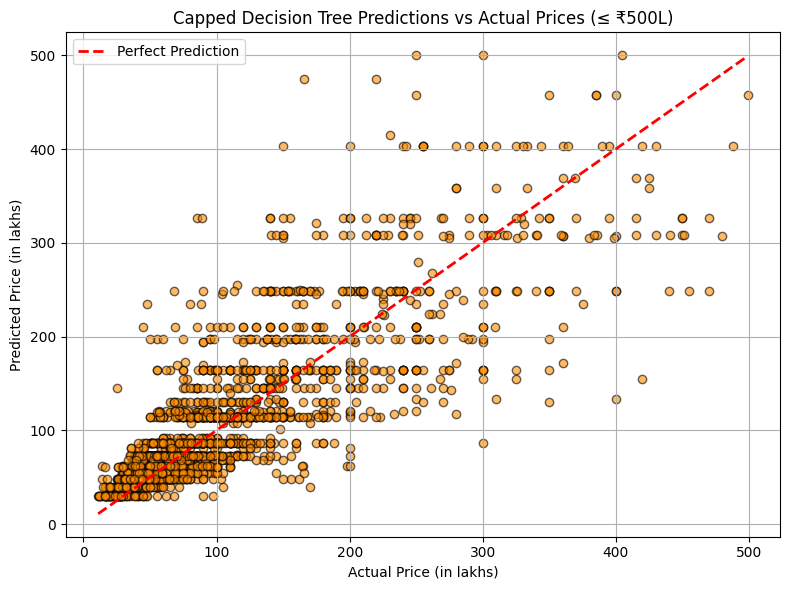

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Cap training prices to ₹500L
y_train_tree_capped = np.minimum(y_train_tree, 500)

# Step 2: Retrain Decision Tree on capped targets
tree_model = DecisionTreeRegressor(max_depth=7, min_samples_split=5)
tree_model.tree = tree_model.fit(X_train_tree, y_train_tree_capped)

# Step 3: Predict on test data
y_pred_tree_capped = tree_model.predict(X_test_tree)

# Step 4: Evaluate only for homes priced ≤ ₹500L
mask = y_test_tree < 500
y_test_sub = y_test_tree[mask]
y_pred_sub = y_pred_tree_capped[mask]

# Handle any potential NaNs in predictions
mask_valid = ~np.isnan(y_pred_sub)
y_test_sub_clean = y_test_sub[mask_valid]
y_pred_sub_clean = y_pred_sub[mask_valid]

# Step 5: Calculate R² Score
r2 = r2_score(y_test_sub_clean, y_pred_sub_clean)
print(f"Capped Decision Tree R² (≤ ₹500L): {r2:.2f}")

# Step 6: Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test_sub_clean, y_pred_sub_clean, alpha=0.6, color='darkorange', edgecolor='k')
plt.plot([y_test_sub_clean.min(), y_test_sub_clean.max()],
         [y_test_sub_clean.min(), y_test_sub_clean.max()],
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.xlabel("Actual Price (in lakhs)")
plt.ylabel("Predicted Price (in lakhs)")
plt.title("Capped Decision Tree Predictions vs Actual Prices (≤ ₹500L)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Implementing KNN

calculate price_per_sqft

In [32]:
df_knn = df_knn[df_knn['total_sqft'] != 0]
df_knn['price_per_sqft'] = (df_knn['price'] * 1e5) / df_knn['total_sqft']

remove price_per_sqft outliers

In [33]:
q1 = df_knn['price_per_sqft'].quantile(0.01)
q99 = df_knn['price_per_sqft'].quantile(0.99)
df_knn = df_knn[(df_knn['price_per_sqft'] > q1) & (df_knn['price_per_sqft'] < q99)]

add sqft per bhk

In [34]:
df_knn['sqft_per_bhk'] = df_knn['total_sqft'] / df_knn['bhk']
df_knn['bath_per_bhk'] = df_knn['bath'] / df_knn['bhk']

define features and target

In [35]:
X_knn = df_knn.drop(columns=['price', 'price_per_sqft'])  # don't include target or engineered helper column
y_knn = df_knn['price']

standardise features

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_knn_scaled = scaler.fit_transform(X_knn)

train-test split

In [37]:
from sklearn.model_selection import train_test_split

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_knn_scaled, y_knn, test_size=0.2, random_state=42
)

manual knn regressor

In [38]:
import numpy as np

def knn_predict(X_train, y_train, X_test, k=5):
    y_pred = []
    for x in X_test:
        distances = np.linalg.norm(X_train - x, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        y_pred.append(np.mean(y_train.iloc[nearest_indices]))
    return np.array(y_pred)

predict and evaluate

In [39]:
y_pred_knn = knn_predict(X_train_knn, y_train_knn, X_test_knn, k=5)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_knn, y_pred_knn)
rmse = np.sqrt(mean_squared_error(y_test_knn, y_pred_knn))
r2 = r2_score(y_test_knn, y_pred_knn)

print(f"KNN MAE: {mae:.2f} lakhs")
print(f"KNN RMSE: {rmse:.2f} lakhs")
print(f"KNN R² Score: {r2:.2f}")

KNN MAE: 31.89 lakhs
KNN RMSE: 77.81 lakhs
KNN R² Score: 0.59


tuning k

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

best_r2 = -1
best_k = None

for k in [3, 5, 7, 10, 15]:
    y_pred_k = knn_predict(X_train_knn, y_train_knn, X_test_knn, k=k)
    mae = mean_absolute_error(y_test_knn, y_pred_k)
    rmse = np.sqrt(mean_squared_error(y_test_knn, y_pred_k))
    r2 = r2_score(y_test_knn, y_pred_k)

    print(f"k = {k} → R²: {r2:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    if r2 > best_r2:
        best_r2 = r2
        best_k = k

k = 3 → R²: 0.61, MAE: 31.48, RMSE: 75.23
k = 5 → R²: 0.59, MAE: 31.89, RMSE: 77.81
k = 7 → R²: 0.58, MAE: 32.54, RMSE: 78.32
k = 10 → R²: 0.59, MAE: 33.25, RMSE: 77.91
k = 15 → R²: 0.57, MAE: 34.20, RMSE: 78.98


further tuning

In [41]:
df_knn = df_knn[df_knn['total_sqft'] < 5000]
df_knn = df_knn[df_knn['sqft_per_bhk'] > 200]

redefine x and y after cleaning

In [42]:
X_knn = df_knn.drop(columns=['price', 'price_per_sqft'])
y_knn = df_knn['price']

rescale and split

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_knn_scaled = scaler.fit_transform(X_knn)

from sklearn.model_selection import train_test_split
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_knn_scaled, y_knn, test_size=0.2, random_state=42
)

predict again with k = 3

In [44]:
y_pred_knn = knn_predict(X_train_knn, y_train_knn, X_test_knn, k=3)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test_knn, y_pred_knn)
rmse = np.sqrt(mean_squared_error(y_test_knn, y_pred_knn))
r2 = r2_score(y_test_knn, y_pred_knn)

print(f"Cleaned KNN (k=3) MAE: {mae:.2f} lakhs")
print(f"Cleaned KNN (k=3) RMSE: {rmse:.2f} lakhs")
print(f"Cleaned KNN (k=3) R² Score: {r2:.2f}")

Cleaned KNN (k=3) MAE: 27.54 lakhs
Cleaned KNN (k=3) RMSE: 56.37 lakhs
Cleaned KNN (k=3) R² Score: 0.66


plot

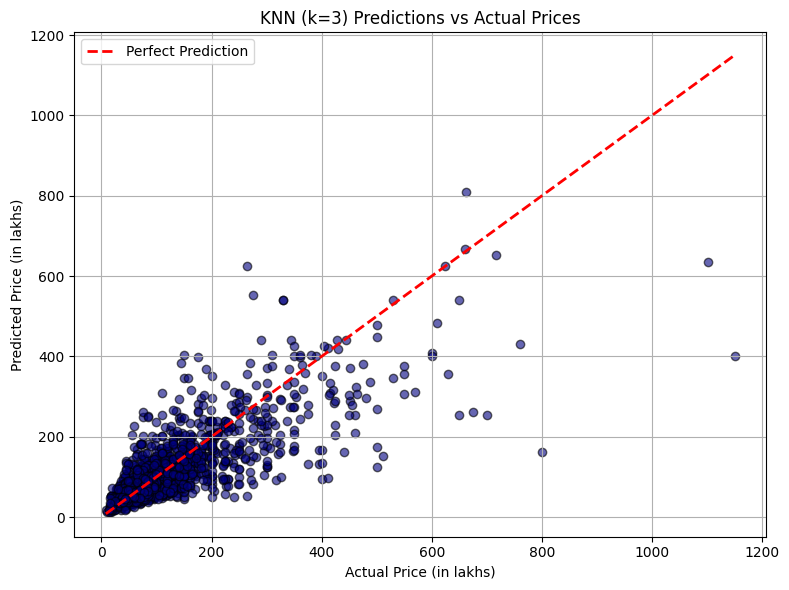

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_knn, y_pred_knn, alpha=0.6, color='navy', edgecolor='k')
plt.plot([y_test_knn.min(), y_test_knn.max()],
         [y_test_knn.min(), y_test_knn.max()],
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.xlabel("Actual Price (in lakhs)")
plt.ylabel("Predicted Price (in lakhs)")
plt.title("KNN (k=3) Predictions vs Actual Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

showing some predictions vs actual values

In [46]:
import pandas as pd
import numpy as np

# Selected number of samples to view
num_samples = 10

# Created DataFrame for comparison
sample_df = pd.DataFrame({
    'Actual Price (L)': y_test_knn[:num_samples].values,
    'Predicted Price (L)': y_pred_knn[:num_samples]
})

# Round for readability
sample_df = sample_df.round(2)

# Display
print(sample_df)

   Actual Price (L)  Predicted Price (L)
0            190.00               153.00
1            188.00                76.33
2             47.00                80.67
3             49.86                52.24
4             65.00                45.17
5            451.00               370.00
6             45.91                48.94
7             78.00                78.25
8             62.00                56.70
9            135.00                78.33


# Trying with log-transformed price

In [47]:
import numpy as np
df_knn['log_price'] = np.log(df_knn['price'])

redefine y

In [48]:
y_knn_log = df_knn['log_price']
X_knn = df_knn.drop(columns=['price', 'price_per_sqft', 'log_price'])

scale and split

In [49]:
scaler = StandardScaler()
X_knn_scaled = scaler.fit_transform(X_knn)

from sklearn.model_selection import train_test_split
X_train_knn, X_test_knn, y_train_knn_log, y_test_knn_log = train_test_split(
    X_knn_scaled, y_knn_log, test_size=0.2, random_state=42
)

predict with knn (k=3)

In [50]:
y_pred_log = knn_predict(X_train_knn, y_train_knn_log, X_test_knn, k=3)

convert predictions back to real prices (exponentiate)

In [51]:
y_pred_exp = np.exp(y_pred_log)
y_test_exp = np.exp(y_test_knn_log)

evaluate

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_exp, y_pred_exp)
rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
r2 = r2_score(y_test_exp, y_pred_exp)

print(f"Log-KNN MAE: {mae:.2f} lakhs")
print(f"Log-KNN RMSE: {rmse:.2f} lakhs")
print(f"Log-KNN R² Score: {r2:.2f}")

Log-KNN MAE: 27.43 lakhs
Log-KNN RMSE: 57.58 lakhs
Log-KNN R² Score: 0.64
